**The goal of the project is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuration. The data is sourced from auction result postings and includes information on usage and equipment configurations.**

# Imports

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
!pip install fastai==0.7.0
!pip install scikit-learn==0.21.3

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 496.4MB 29kB/s 
     |████████████████████████████████| 1.5MB 31.6MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2663662 sha256=125e9573fd31bffa691c051fce5c453184f817a2b6150f388914664a2e65e5e6
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: fastai 1.0.60
    Uninstalling fastai-1.0.60:
      Successfully uninstalled fastai-1.0.60
     |████████████████████████████████| 6.7MB 2.8MB/s 
  Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1


In [0]:
from fastai.imports import *
from fastai.structured import *

import sklearn
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [0]:
drive.flush_and_unmount()

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.getcwd()

'/content'

In [0]:
os.chdir('/content/drive/My Drive/Fastai/ml/')
PATH = "data/bulldozers/"

In [0]:
!ls {PATH}

Test.csv  Train.csv  Valid.csv


# The data

### Look at the data


- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012. 

The key fields are in train.csv are:

- SalesID: the unique identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

In [0]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])



*   parse_dates — A list of any columns that contain dates
*   low_memory=False — Forces it to read more of the file to decide what the 
types are.



In [0]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [0]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [0]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaT,NaT,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaT,NaT,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaT,NaT,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaT,NaT,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaT,NaT,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaT,NaT,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaT,NaT,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaT,NaT,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17,2011-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Metric to be used is **RMSLE** (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [0]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

### Initial processing


The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals. 

In [0]:
def add_date_part(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, 
                                     infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 
            'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
            'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)


*   getattr — look inside of an object and finds an attribute with that name
*   drop=True — unless specified, it will drop the date time field because we cannot use “saledate” directly because it is not a number.



In [0]:
add_date_part(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

The categorical variables are currently stored as strings, which is inefficient and not the right way to give to the model, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

`train_cats` is called “train” because it is training data specific. It is important that validation and test sets will use the same category mappings

In [0]:
def train_cats(df):
  for n,c in df.items():
    if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [0]:
train_cats(df_raw)

We can specify the order to use for categorical variables if we wish:

In [0]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [0]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [0]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a random forest.

In [0]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

Here we will save it in a `feather format`. What this is going to do is to save it to disk in exactly the same basic format that it is in RAM. This is by far the fastest way to save something, and also to read it back.

In [0]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

### Pre-processing

In the future we can simply read it from this fast format.

In [0]:
df_raw = pd.read_feather('tmp/bulldozers-raw')

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [0]:
df, y, nas = proc_df(df_raw, 'SalePrice')


*   df — data frame
*   y_fld — name of the dependent variable
*   It makes a copy of the data frame, grab the dependent variable values (y_fld), and `drop the dependent variable from the data frame`.
*   Then it will `fix_missing` 
*   We then will go through the data frame and call `numericalize` 

**fix_missing**: 
*   For numeric data type, first it checks if there is null column. If so, it will create a new column with a name with `_na` appended at the end and set it to 1 if it is missing; 0 otherwise (boolean). 

*   It will then `replace the missing value with a median.`

*   We do not need to do this for categorical variables because Pandas handles them automatically by setting them to -1 .

**numericalize**:

*   If it is not numeric and is a categorical type, we will replace the column with its code plus 1.

*   By default pandas uses -1 for missing, so now missing will have an ID of 0 .

We now have something we can pass to a random forest!

In [0]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9829633565229624

Random forests are **trivially parallelizable** — meaning if you have more than one CPU, you can split up the data across different CPUs and it linearly scale

`n_jobs=-1` tells the random forest regressor to create a separate job/process for each CPU you have.

In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

Wow, an r^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:


![alt text](https://i.stack.imgur.com/t0zit.png)



The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem.

In [0]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

# Random Forests

### Base model

Let's try our model again, this time with separate training and validation sets.

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [0]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 36s, sys: 142 ms, total: 1min 37s
Wall time: 49.6 s
[0.09041337149108199, 0.25238126759802126, 0.9829155833382898, 0.8862471703915356]


An r^2 in the high-80's isn't bad at all (and the RMSLE puts us around rank 100 of 470 on the Kaggle leaderboard), but we can see from the validation set score that we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

### Speeding things up

One way to speed things up is to pass in the subset parameter to proc_df which will randomly sample the data:

In [0]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)


*   Be careful to make sure that validation set does not change
*   Also make sure that training set does not overlap with the dates



As you see above, when calling split_vals, we do not put the result to a validation set.

 _ indicates that we are throwing away the return value. We want to keep validation set the same all the time.

In [0]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 4.03 s, sys: 6.87 ms, total: 4.03 s
Wall time: 2.17 s
[0.11144759438934115, 0.37838471854520717, 0.9730092988255378, 0.7443091709607754]


After resampling the training set into the first 20,000 out of a 30,000 subsets, it runs in 2 seconds.

### Hyper-parameter tuning - n_estimators

In [0]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.11187704207354855, 0.379496723671962, 0.9728008882895113, 0.742804103257799]


`n_estimators` by default is 10 (remember, estimators are trees).

We'll grab the predictions for each individual tree, and look at one example.

In [0]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([9.5819 , 9.04782, 9.43348, 9.10498, 9.30565, 8.92266, 9.51044, 9.10498, 9.15905, 9.30565]),
 9.247662045191475,
 9.104979856318357)

In [0]:
preds.shape

(10, 12000)

*   Each tree is stored in an attribute called estimators_ . 
*   For each tree, we will call predict with our validation set. 
*   np.stack concatenates them together on a new axis, so the resulting preds has the shape of (10, 12000) (10 trees, 12000 validation set).
*    The mean of 10 predictions for the first data is 9.24, and the actual value is 9.10. 

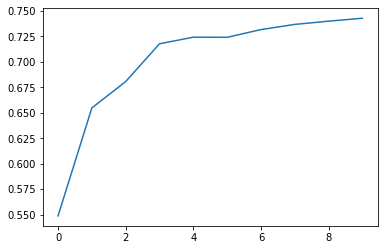

In [0]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [0]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10032861115765783, 0.3645013727578756, 0.978126294003132, 0.7627280986091094]


In [0]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09638540861687464, 0.3623109830902638, 0.9798119042699448, 0.7655711954833947]


In [0]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09284767288932902, 0.35628429759664604, 0.9812666772254336, 0.7733053147113116]


As you see, adding more trees do not help much. It will not get worse but it will stop improving things much. This is the first hyper parameter to learn to set — a number of estimators. 

### Hyper-parameter tuning - Out-of-bag (OOB) score

Sometimes your dataset will be small and you will not want to pull out a validation set because doing so means you now do not have enough data to build a good model. 

However, random forests have a very clever trick called out-of-bag (OOB) error which can handle this (and more!)

What we could do is to recognize that in our first tree, some of the rows did not get used for training. What we could do is to pass those unused rows through the first tree and treat it as a validation set. 

For the second tree, we could pass through the rows that were not used for the second tree, and so on. 

Effectively, we would have a different validation set for each tree. To calculate our prediction, we would average all the trees where that row is not used for training. 

If you have hundreds of trees, it is very likely that all of the rows are going to appear many times in these out-of-bag samples. You can then calculate RMSE, R², etc on these out-of-bag predictions.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [0]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09560325282909496, 0.3626570285046883, 0.9801382227081764, 0.7651231728887705, 0.8574720946115442]


This shows that our validation set time difference is making an impact, as is model over-fitting.

## Reducing over-fitting

### Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [0]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [0]:
set_rf_samples(20000)

In [0]:
m = RandomForestRegressor(n_jobs=-1, oob_score=False)
%time m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 8.44 s, sys: 74.9 ms, total: 8.52 s
Wall time: 4.99 s
[0.24005828810799762, 0.28107089621036996, 0.8795606964249043, 0.8589153611231647]


Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [0]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=False)
m.fit(X_train, y_train)
print_score(m)

[0.2274206560046355, 0.26315980771455877, 0.8919077288566615, 0.8763235260838312]


Scikit-learn does not support this out of box, so set_rf_samples is a custom function. So OOB score needs to be turned off when using set_rf_samples as they are not compatible. reset_rf_samples() will turn it back to the way it was.

The **biggest tip**: Most people run all of their models on all of the data all of the time using their best possible parameters which is just pointless. If you are trying to find out which feature is important and how they are related to each other, having that 4th decimal place of accuracy is not going to change any of your insights at all. Do most of your models on a large enough sample size that your accuracy is reasonable (within a reasonable distance of the best accuracy you can get) and taking a small number of seconds to train so that you can interactively do your analysis.

### Tree building parameters

**Baseline till point**



We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [0]:
reset_rf_samples()

Let's get a baseline for this full set to compare to.

In [0]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07829510533532183, 0.23873232421469223, 0.9871883799176899, 0.8982181298469987, 0.9084493407337565]


Here OOB is higher than validation set. This is because our validation set is a different time period whereas OOB samples are random. It is much harder to predict a different time period.

#### min_smaples_leaf

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with **`min_samples_leaf`**) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility
-  1, 3, 5, 10, 25, 100

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.14071764539335962, 0.23383744330030304, 0.9586160495754561, 0.902349137873678, 0.9071047544146076]


In [0]:
t=m.estimators_[0].tree_

In [0]:
dectree_max_depth(t)

35

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11498340341226969, 0.23332031967241335, 0.9723684565459612, 0.90278056348749, 0.9087475309902073]


#### max_features

We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

- None
- 0.5
- 'sqrt'

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11890219731651028, 0.22714220073382982, 0.9704529187083963, 0.9078609707154432, 0.912154800486509]


`max_features=0.5` : The idea is that the less correlated your trees are with each other, the better. Imagine you had one column that was so much better than all of the other columns of being predictive that every single tree you built always started with that column. But there might be some interaction of variables where that interaction is more important than the individual column.

So if every tree always splits on the same thing the first time, you will not get much variation in those trees.
In addition to taking a subset of rows, at every single split point, take a different subset of columns.


For row sampling, each new tree is based on a random set of rows, for column sampling, every individual binary split, we choose from a different subset of columns.
0.5 means randomly choose a half of them. There are special values you can use such as sqrt or log2
Good values to use are `0.5, log2, or sqrt`


The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)

In [0]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [0]:
t=m.estimators_[0].tree_

In [0]:
dectree_max_depth(t)

45

# Model interpretation

**Load progress till point**



In [0]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [0]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [0]:
set_rf_samples(50000)

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20618392612920597, 0.2494955264845467, 0.9111526586924948, 0.8888336106768512, 0.893989848150342]


## Confidence based on tree variance

We saw how the model averages predictions across the trees to get an estimate - but how can we know the `confidence of the estimate?` One simple way is to use the `standard deviation` of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [0]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.28 s, sys: 62 ms, total: 1.34 s
Wall time: 1.34 s


(9.238397427434753, 0.23720551670913617)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [0]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 80.1 ms, sys: 103 ms, total: 183 ms
Wall time: 1.53 s


(9.238397427434753, 0.23720551670913617)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

We will first create a copy of the data and add the `standard deviation` of the predictions and `predictions` themselves (the mean) as new columns:

In [0]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

Let's plot one categorical column

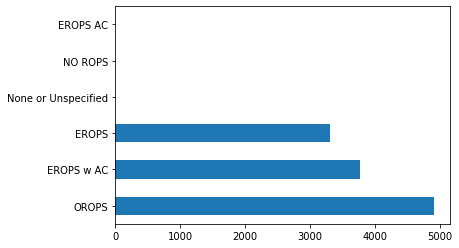

In [0]:
x.Enclosure.value_counts().plot.barh();

In [0]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.837431,0.272183
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.571218,0.264541
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.684261,0.219451


Took the data frame, grouped by Enclosure, then took average of 3 fields

Can already start to learn a little here:
- Prediction and the sale price are close to each other on average (good sign)
- Standard deviation varies a little bit

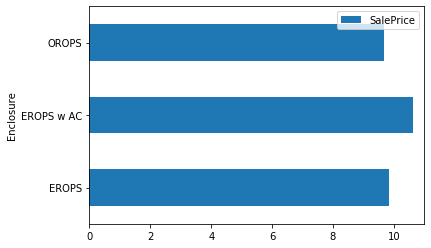

In [0]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

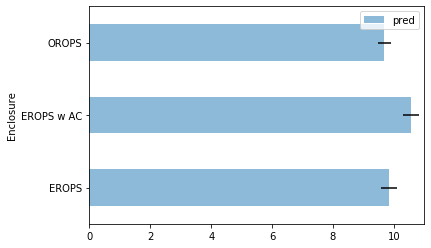

In [0]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.5, xlim=(0,11));

We used the standard deviation of prediction for the error bars above. This will tell us if there is some groups or some rows that we are not very confident of at all.

**Lets do something similar for product size:**


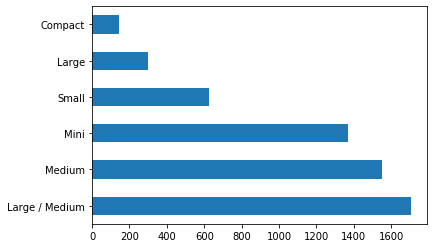

In [0]:
raw_valid.ProductSize.value_counts().plot.barh();

In [0]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.841372,0.356352
Large,10.470589,10.396246,0.352915
Large / Medium,10.691871,10.640530,0.294075
Medium,10.681511,10.623219,0.282298
Mini,9.535147,9.556561,0.245324
Small,10.324448,10.318066,0.307603


You expect, on average, when you are predicting something that is a bigger number your standard deviation would be higher. So you can sort by the ratio of the standard deviation of the predictions to the predictions themselves 

In [0]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.036210
Large             0.033946
Small             0.029812
Large / Medium    0.027637
Medium            0.026574
Mini              0.025671
dtype: float64

What this tells us is that product size Large and Compact , our predictions are less accurate (relatively speaking as a ratio of the total price). So if we go back and have a look, you see why. These are the smallest groups in the histogram. 

You can use this confidence interval for two main purposes:
- You can look at the average confidence interval by group to find out if there are groups you do not seem to have confidence about.

- Perhaps more importantly, you can look at them for specific rows. When you put it in production, you might always want to see the confidence interval. For example, if you are doing credit scoring to decide whether to give somebody a loan, you probably want to see not only what their level of risk is but how confident we are. If they want to borrow lots of money and we are not at all confident about our ability to predict whether they will pay back, we might want to give them a smaller loan.

## Feature Importance

The feature importance tells us in this random forest, which columns mattered. We have dozens of columns in this dataset, and here, we are picking out the top 10.

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [0]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.178277
13,ProductSize,0.105452
37,Coupler_System,0.091741
14,fiProductClassDesc,0.069329
2,ModelID,0.053857
63,saleElapsed,0.050128
10,fiSecondaryDesc,0.047888
38,Grouser_Tracks,0.037563
39,Hydraulics_Flow,0.037080
19,Enclosure,0.035625


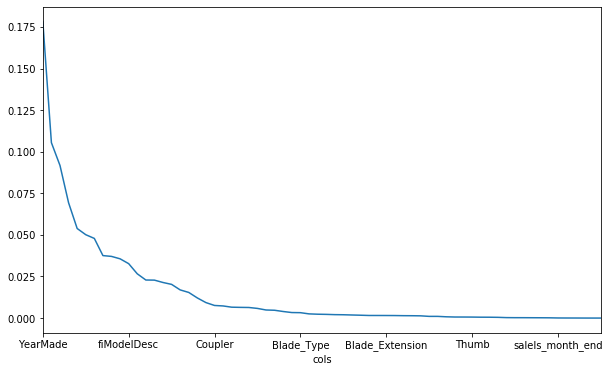

In [0]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In nearly every dataset you use in real life, this is what your feature importance is going to look like. There is only a handful of columns that you care about.

At this point, in terms of looking into learning about this domain of heavy industrial equipment auctions, we only have to care about learning about the columns which matter.

We can also plot this as a bar plot:

In [0]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

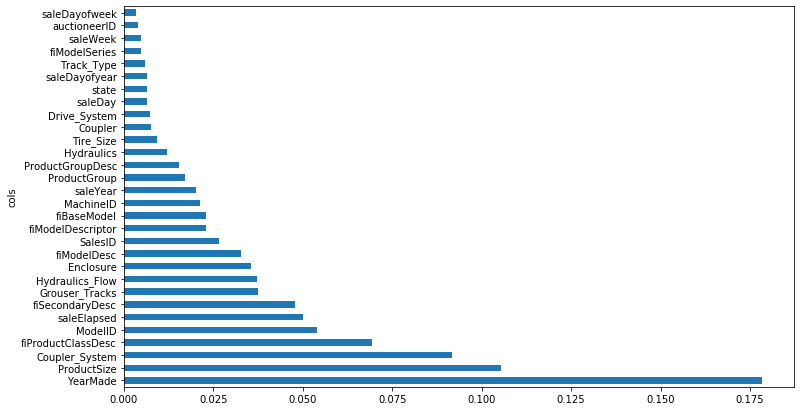

In [0]:
plot_fi(fi[:30]);

To make life easier, it is sometimes good to throw some data away and see if it make any difference. In this case, we have a random forest which was .890 r². Here we filter out those where the importance is equal to or less than 0.005 (i.e. only keep the one whose importance is greater than 0.005).

In [0]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

26

In [0]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20623537710989595, 0.2436283407418608, 0.9111083113635344, 0.8940005556233301, 0.8948113301249917]


The r² did not change much — it actually increased a tiny bit. Generally speaking, removing redundant columns should not make it worse. If f it makes it worse, they were not redundant after all.

Let’s re-run feature importance on this new result

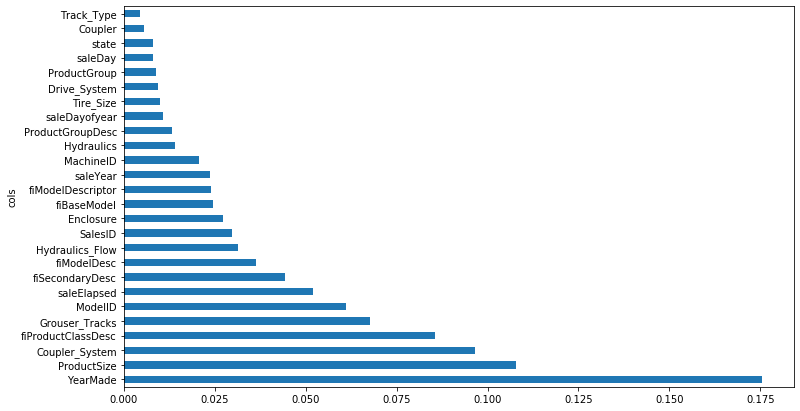

In [0]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

**Internal working of feature importance:**

- We take our bulldozer data set and we have a column Price we are trying to predict (dependent variable).
- We have 25 independent variables and one of them is YearMade.
- How do we figure out how important YearMade is? We have a whole random forest and we can find out our predictive accuracy. So we will put all these rows through our random forest, and it will spit out some predictions. We will then compare them to the actual price (in this case, we get our root mean squared error and r²). This is our starting point.
- Let’s do exactly the same thing, but this time, take the YearMade column and randomly shuffle it (i.e. randomly permute just that column). Now YearMade has exactly the same distribution as before (same mean, same standard deviation). But it has no relationships with our dependent variable at all because we totally randomly reordered it.
- Before, we might have found our r² was .89. After we shuffle YearMade, we check again, and now r² is .80. The score got much worse when we destroyed that variable.
- Okay, let’s try again. We put YearMade back to how it was, and this time let’s take Enclosure and shuffle that. This time, r²is .84 and we can say the amount of decrease in our score for YearMade was .09 and the amount of decrease for Enclosure was .05. And this is going to give us our feature importances for each column.

### One Hot Encoding

we can do one hot encoding easily enough and the way we do it is we pass one extra parameter to `proc_df` which is what is the max number of categories (max_n_cat). 

So if we say it’s seven, then anything with less than seven levels is going to be turned into a one-hot encoded bunch of columns.

In [0]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20770342321621785, 0.25688804049669356, 0.909838291076749, 0.8821483286381083, 0.8921021103943619]


 you can see what happens to the R² of the validation set and to the RMSE of the validation set. In this case, I found it got a little bit worse. This isn’t always the case and it’s going to depend on your dataset. It depends on if you have a dataset where single categories tend to be quite important or not. In this particular case, it did not make it more predictive.

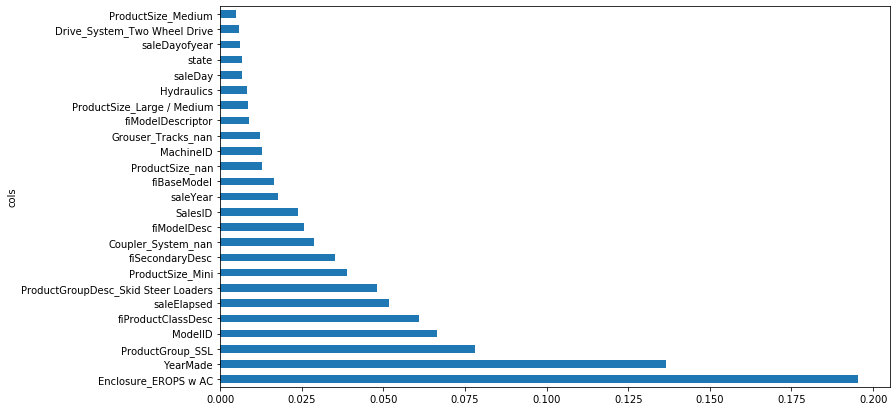

In [0]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

we now have different features. proc_df puts the name of the variable, an underscore, and the level name. So interestingly, it turns out that before, it said that enclosure was somewhat important. When we do it as one hot encoded, it actually says Enclosure_EROPS w AC is the most important thing. So for at least the purpose of interpreting your model, you should always try one hot encoding quite a few of your variables.

## Removing redundant features using Cluster Analysis

We’ve already seen how variables which are basically measuring the same thing can confuse our variable importance. They can also make the model slightly less good because it requires more computation to do the same thing and there’re more columns to check. So let's do some more work to try and remove redundant features.

**`Cluster analysis`** is something where you are trying to look at objects, they can be either rows in the dataset or columns and find which ones are similar to each other.

- `Spearman’s R` is used for finding the correlation
- Correlation is almost exactly the same as the R², but it’s between two variables rather than a variable and its prediction.
- The problem with a normal correlation is that if you have data that looks like this then you can do a correlation and you’ll get a good result.

![alt text](https://miro.medium.com/max/653/1*dObn_o4F0-bWOGtdAkajkA.png)

But if you’ve got data which looks like this and you try and do a correlation (assuming linearity), that’s not very good.

![alt text](https://miro.medium.com/max/886/1*MBizy1nyW_8LP5I2xhrhNw.png)

So there is a thing called a `rank correlation` which is a really simple idea. Replace every point by its rank.

- From left to right, we rank from 1, 2, …6. Then we do the same for the y-axis. 
- Then we create a new plot where you don’t plot the data but plot the rank of the data. 
- If you think about it, the rank of this dataset is going to look like an exact line because every time something was greater on the x-axis, it was also greater on the y-axis. So if we do a correlation on the rank, that’s called a rank correlation.

![alt text](https://miro.medium.com/max/1454/1*ETf92aZgRGcdhXCkSPQ70w.png)

**Spearman’s R is the name of the most common rank correlation.**

In [0]:
from scipy.cluster import hierarchy as hc

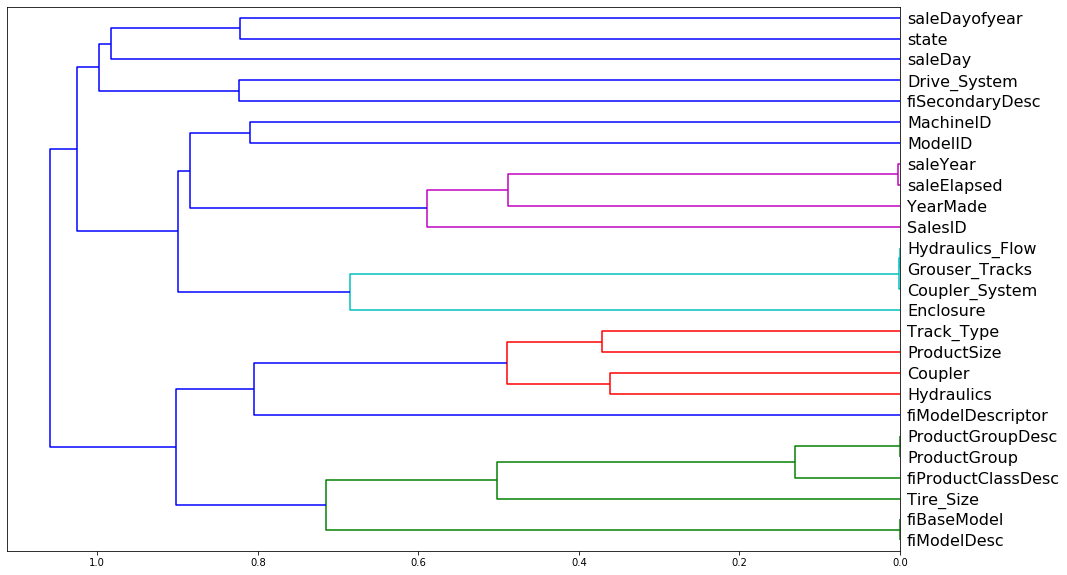

In [0]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

we can see which two variables are the most similar. saleYear and saleElapsed are very similar. So the horizontal axis here is how similar are the two points that are being compared. If they are closer to the right, that means that they are very similar. So saleYear and saleElapsed have been combined and they were very similar.

- saleYear and saleElapsed are measuring basically the same thing (at least in terms of rank) which is not surprising because saleElapsed is the number of days since the first day in my dataset so obviously these two are nearly entirely correlated.
- Grouser_Tracks, Hidraulics_Flow, and Coupler_System all seem to be measuring the same thing. This is interesting because, Coupler_System was super important feature as seen in feature importance. So this rather supports our hypothesis there is nothing to do with whether it’s a coupler system but whether it is whatever kind of vehicle it is has these kind of features.
- ProductGroup and ProductGroupDesc seem to be measuring the same thing, and so are fiBaseModel and fiModelDesc

Let's try removing some of these related features one at a time to see if the model can be simplified without impacting the accuracy.

In [0]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [0]:
get_oob(df_keep)

0.8899275472857162

Now we try removing each variable one at a time.

In [0]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8902593038594155
saleElapsed 0.8866069128435344
fiModelDesc 0.8896402723092374
fiBaseModel 0.8890738700114814
Grouser_Tracks 0.8904537863249598
Coupler_System 0.8903556753188347


It looks like we can try one from each group for removal. Let's see what that does.

In [0]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8879553932505384

We’ve gone from .889 to .887, it’s so close as to be meaningless. So that sounds good. Simpler is better. So I’m now going to drop these columns from my data frame, and then I can try running the full model again.

In [0]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [0]:
keep_cols = np.load('tmp/keep_cols.npy', allow_pickle=True)
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [0]:
reset_rf_samples()

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12571275674582397, 0.22773739626520753, 0.9669711444002966, 0.9073774622374838, 0.9084351093054397]


## Partial dependence

- Now it's the point to really understand the data better by taking advantage of the model. And lets use something called `partial dependence`.  
- we are going to find out, for the features that are important, how do they relate to the dependent variable.

- This is a lot like the way we did feature importance. 
- But rather than randomly shuffling the column, we are going to replace the column with a constant value.
- Randomly shuffling the column tells us how accurate it is when you don’t use that column anymore.
- Replacing the whole column with a constant estimates for us how much we would have sold that product for in that auction on that day in that place if that product had been made in 1961.

In [0]:
#!pip install pdpbox

In [0]:
from pdpbox import pdp
from plotnine import *

In [0]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again. As I am actually pretty interested in seeing the individual levels for interpretation.

In [0]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

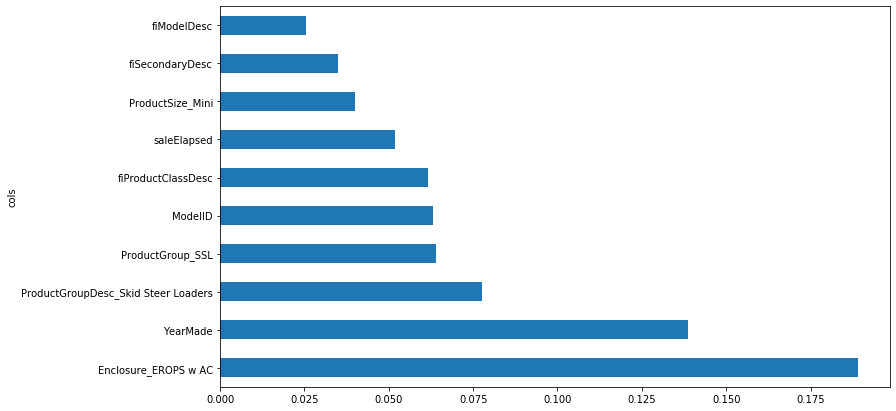

In [0]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

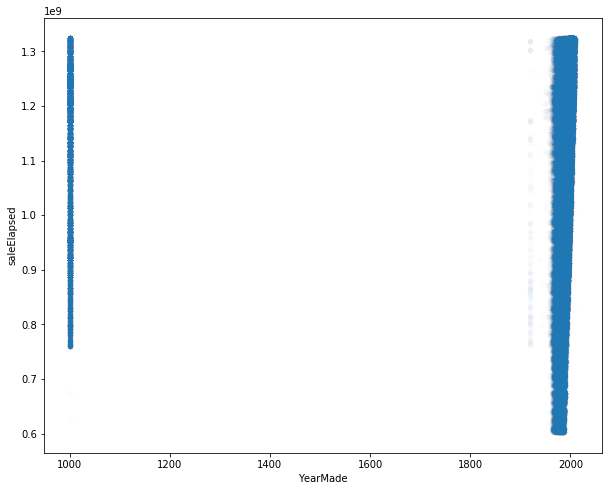

In [0]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

- When we do, we get this very ugly graph. It shows us that YearMade actually has a whole bunch that are a thousand
- I’m just going to remove them from this interpretation section of the analysis and will just grab things where YearMade is greater than 1930.

In [0]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

In [0]:
#!pip install scikit-misc

     |████████████████████████████████| 9.2MB 2.8MB/s 


Let’s now look at the relationship between YearMade and SalePrice

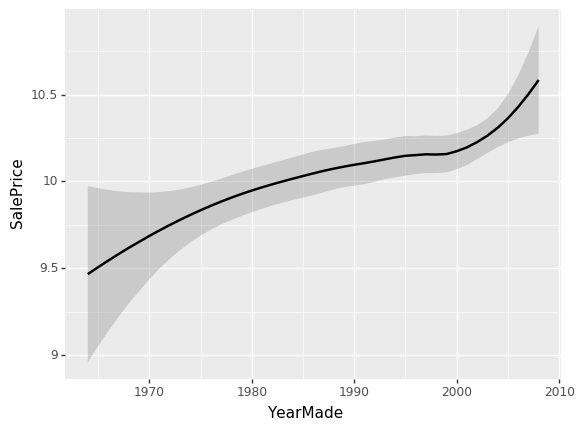

<ggplot: (-9223363310169242273)>

In [0]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

By adding standard error equals true (se=True), it also shows me the confidence interval of this smoother. loess stands for locally weighted regression which is this idea of doing lots of little mini regressions.

- So we can see here, the relationship between YearMade and SalePrice is all over the place which is not really what we would expect.
-  I would have expected that stuff that’s sold more recently would probably be more expensive because of inflation and they are more current models.
-  The problem is that when you look at a univariate relationship like this, there is a whole lot of collinearity going on — a whole lot of interactions that are being lost.

**why did the price drop?**
- Is it actually because things made between 1991 and 1997 are less valuable? 
- Is it actually because most of them were also sold during that time and there was maybe a recession then? 
- Was it because products sold during that time, a lot more people were buying types of vehicles that were less expensive?

**Well, what’s the relationship between SalePrice and YearMade all other things being equal.**
All other things being equal” basically means if we sold something in 1990 vs. 1980 and it was exactly the same thing to exactly the same person in exactly the same auction so on and so forth, what would have been the difference in price? 

To do that, we do something called a `partial dependence plot`

In [0]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [0]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)
    

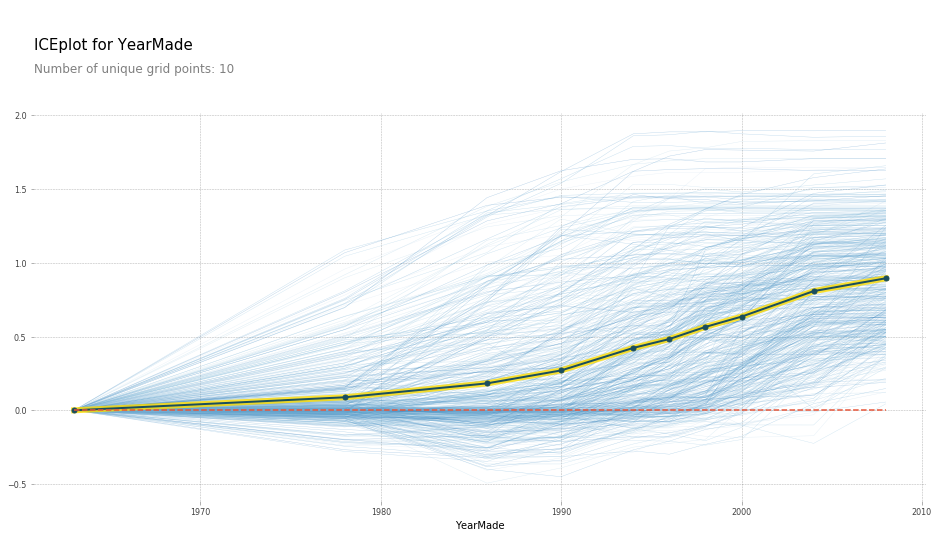

In [0]:
plot_pdp('YearMade')

So what the partial dependence plot (PDP)here shows us is:
- Each of these light blue lines actually is showing us all 500 lines.
- So for row number 1 in our dataset, if we sold it in 1960, we are going to index that to zero so call that zero. If we sold it in 1970 that particular auction, it would have been here, etc. 
- We actually plot all 500 predictions of how much every one of those 500 auctions would have gone for if we replaced its YearMade with each of these different values. 
- Then this dark line is the average. So this tells us how much would we have sold on average all of those auctions for if all of those products were actually made in 1985, 1990, 1993, etc.

There is another cool thing we can do with PDP which is we can use clusters. What clusters does is it uses cluster analysis to look at each one of the 500 rows.

We could kind of see it seems like there’s a whole a lot of rows that go down and then up, and there seems to be a bunch of rows that go up and then go flat. 

It does seem like there’s some kind of different types of behaviors being hidden and so here is the result of doing that cluster analysis:

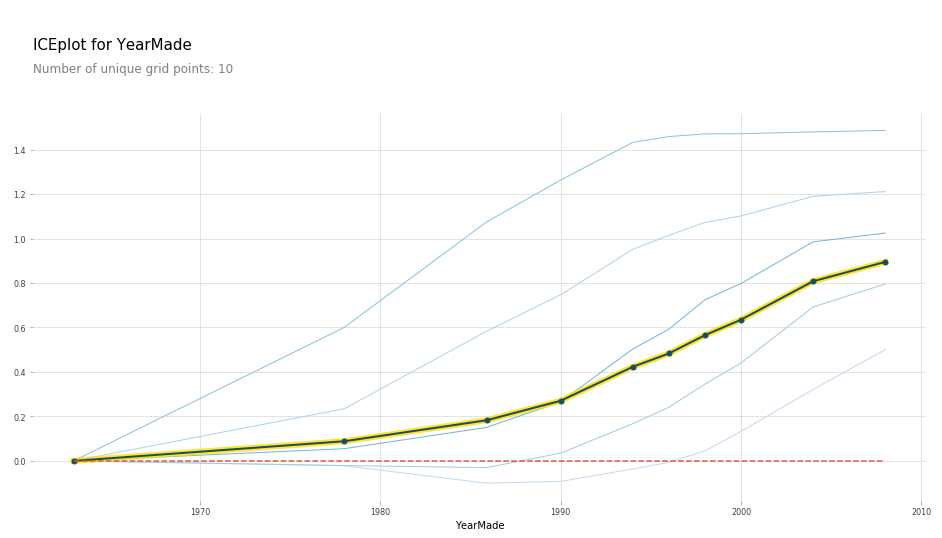

In [0]:
plot_pdp('YearMade', clusters=5)

**Important point(Limitation):**
- If you’ve got a datapoint that’s in a part of the space that the model has not seen before, like maybe people didn’t put air conditioning in bulldozers in 1960 and you are saying how much would this bulldozer with air conditioning would have gone for in 1960, you don’t really have any information to know that and so that may cause poor prediction at a point.
- This is still the best technique, but it’s not perfect. And you kind of hope that the trees are still going to find some useful truth even though it hasn’t seen that combination of features before. But yeah, it’s something to be aware of.

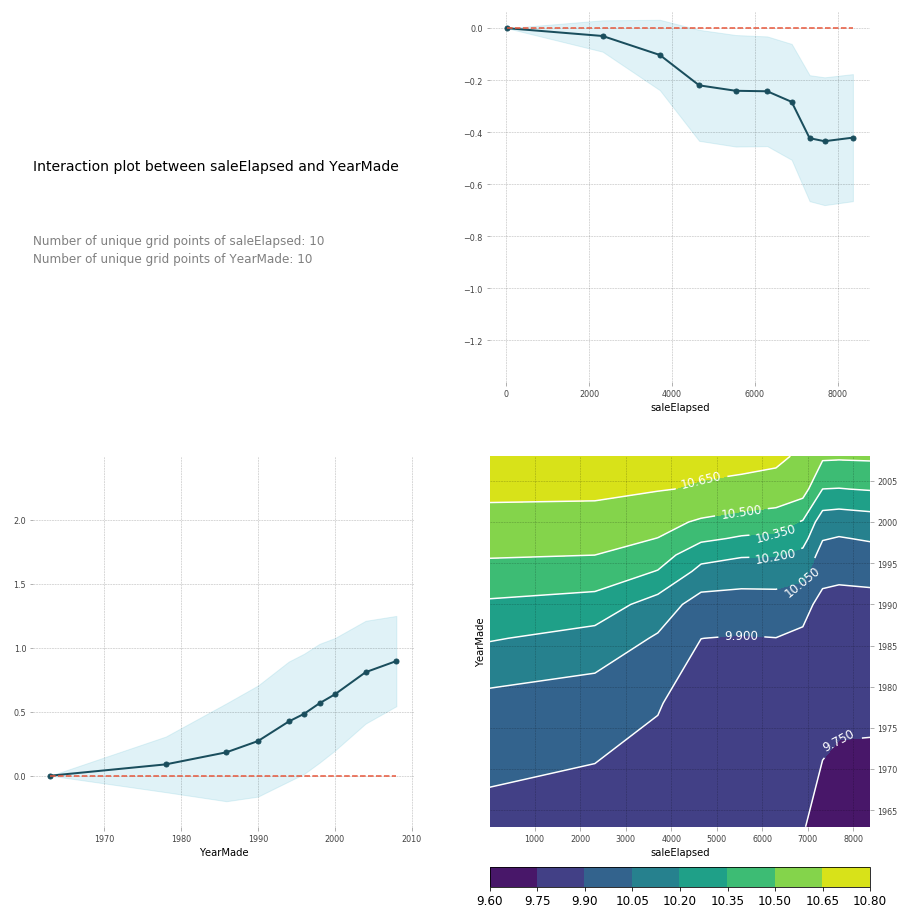

In [0]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

**Interaction plot**
It shows saleElapsed vs. price, YearMade vs. price, and the combination vs. price. 
- You can see that the combination of saleElapsed and YearMade is as you would expect —the highest prices are those where there’s the least elapsed and the most recent year made. 
- It’s enough to see clearly that these two things are driving price together.
- You can also see these are not simple diagonal lines so there is some interesting interaction going on. 
- Based on looking at these plots, we should maybe put in some kind of interaction term and see what happens. 

*Remember, this is always log of price. That’s why these prices look weird.*

Let’s just look at a couple more.

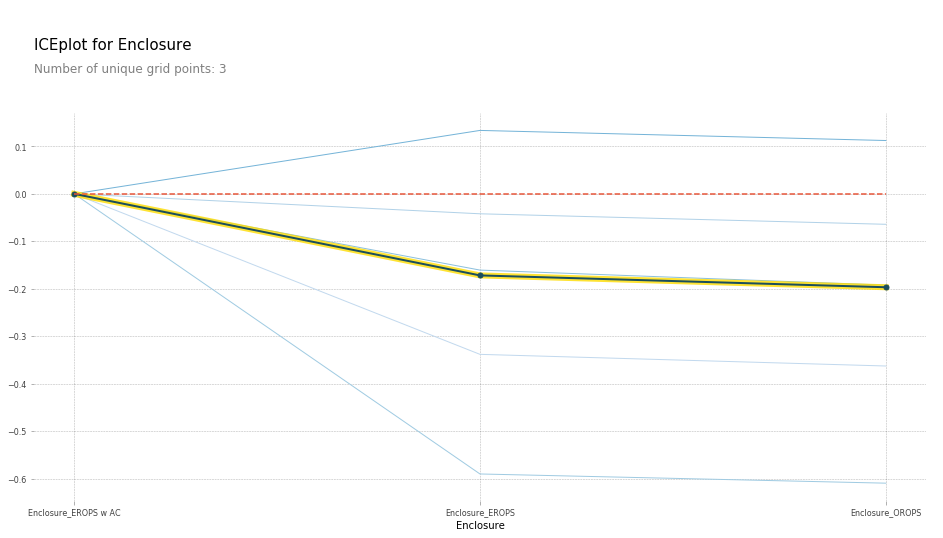

In [0]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

- `Enclosure_EROPS w AC` on average are more expensive than `Enclosure_EROPS` or `Enclosure_OROPS`. It actually looks like the latter two are pretty similar or else `Enclosure_EROPS w AC` is higher.

- `EROPS` is enclosed rollover protective structure and so it turns out that if your bulldozer is fully enclosed then optionally you can also get air conditioning. 

**Based on the earlier interaction analysis:**

- Setting everything before 1950 to 1950 because it seems to be some kind of missing value. 
- Let's create a feature named `age` to be equal to saleYear - YearMade.

In [0]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

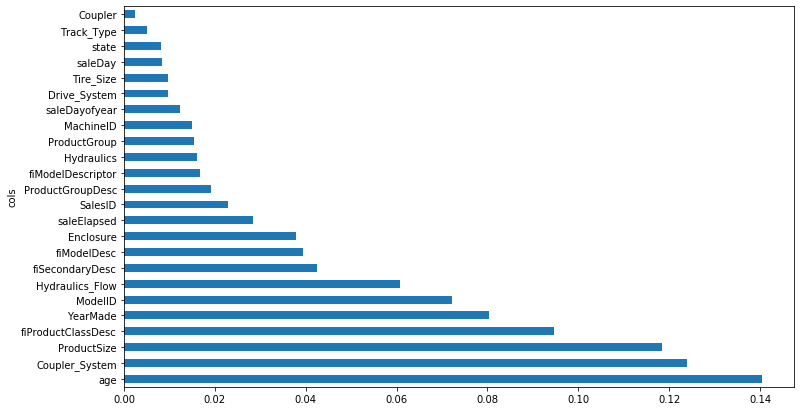

In [0]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

Indeed, `age` is now the single biggest feature

## Tree interpreter

In general, you’ve made a prediction for a record from some model and somebody asks why. This is where we use this method called tree interpreter to explain. What tree interpreter does is it allows us to take a particular row.

In [0]:
!pip install treeinterpreter

In [0]:
from treeinterpreter import treeinterpreter as ti

In [0]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

So in this case, we are going to pick row number zero.

In [0]:
row = X_valid.values[None,0]; row

array([[      1999,          5,          0,         17,        665, 1284595200,          0,          0,
                 1,       3232,    4364751,          0,    2300944,          4,          4,         12,
                 0,          3,          0,         16,         35,        259,          2,         11]])

In [0]:
row

array([[      1999,          5,          0,         17,        665, 1284595200,          0,          0,
                 1,       3232,    4364751,          0,    2300944,          4,          4,         12,
                 0,          3,          0,         16,         35,        259,          2,         11]])

Here are all the columns in row zero.

In [0]:
prediction, bias, contributions = ti.predict(m, row)

What we can do with a tree interpreter is we can go ti.predict, pass in the random forest model and the row (so this would be like this particular auction and it will give me back three things:
- prediction: The prediction from the random forest
- bias: The average sale price across the whole original dataset
- contributions: A column and the value to split by (i.e. the predictor), and how much it changed the predicted value.

**Example:**

Lets say wthe model predicted 10.2 log(price) for a model with such features `Coupler_system` ≤ 0.5, `Coupler_system` ≤ 0.5 , `Enclosure` ≤ 2.0  and `ModelID` ≤ 4573.0. 

Lets see how:
![alt text](https://miro.medium.com/max/1474/1*O-07xrFQS6Oyz0EqAIUOoQ.png)

That is because we started with 10.19:
- Because the coupler system was less than .3, we added about .2 to that (so we went from 10.19 to 10.34).
- Because enclosure was less than 2, we subtracted about .4.
- Then because model ID was less than 4573, we added about .7

So we can see with a single tree, we could break down why is it that we predicted 10.2.

At each one of these decision points, we are adding or subtracting a little bit from the value. What we could then do is we could do that for all the trees and then we could take the average.

That is what a `tree interpreter` does, it explains the contribution for every feature to the final prediction

In [0]:
prediction[0], bias[0]

(array([9.33274]), 10.105528873698129)

`Bias` is just the average before we start doing any splits 

In [0]:
idxs = np.argsort(contributions[0])

In [0]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5951659310728132),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.11837757026821523),
 ('age', 11, -0.10886883603119797),
 ('fiModelDesc', 'KX1212', -0.09419595438941344),
 ('SalesID', 4364751, -0.0412762901324736),
 ('fiSecondaryDesc', nan, -0.0345252994282379),
 ('Enclosure', 'EROPS', -0.03187816351608164),
 ('fiModelDescriptor', nan, -0.02035489165902815),
 ('saleDayofyear', 259, -0.01525920163974961),
 ('Tire_Size', nan, -0.014884838568239144),
 ('saleDay', 16, -0.012490121726103887),
 ('state', 'Ohio', -0.009843452058712288),
 ('MachineID', 2300944, -0.005060917445978141),
 ('Coupler', 'None or Unspecified', 0.004164450245674534),
 ('Drive_System', nan, 0.005184988660960954),
 ('ProductGroupDesc', 'Track Excavators', 0.01040255538545396),
 ('saleElapsed', 1284595200, 0.015318720750094262),
 ('ProductGroup', 'TEX', 0.016815735116428643),
 ('Hydraulics', 'Standard', 0.0178646427565738),
 ('Track_Type', 'Steel', 0.025

In [0]:
contributions[0].sum()

-0.7727867476903696

## Extrapolation

**Here is the problem with random forests when it comes to extrapolation.**

- When you’ve got a dataset that got four years of sales data in it, and you create your tree and it says if it’s in some particular store and some particular item and it is on special, here is the average price. And it actually tells us the average price over the whole training set which could be pretty old. 
- So when you then want to step forward to what is going to be the price next month, it’s never seen next month. Where else with a linear model, it can find a relationship between time and price where even though we only had this much data, when you then go and predict something in the future, it can extrapolate that. But a random forest can’t do that. 
- There is no way for a tree to be able to say well next month, it would be higher still. 
- One simple way is just to try to avoid using time variables as predictors if there’s something else we could use that’s going to give us a better or stronger relationship that’s actually going to work in the future

So Lets create a random forest where my dependent variable is “is it in the validation set” (is_valid). and use that as the dependent variable and build a random forest. 

- This is a random forest not to predict price but predict is this in the validation set or not. 
- If your variable were not time dependent, then it shouldn’t be possible to figure out if something is in the validation set or not.

In [0]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999900280461202

In [0]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.833197
5,saleElapsed,0.122243
12,MachineID,0.033995
21,saleDayofyear,0.003130
0,YearMade,0.002369
9,fiModelDesc,0.001905
23,age,0.001157
4,ModelID,0.000857
2,Coupler_System,0.000337
15,Hydraulics,0.000314


In this case, we can see we don’t have a random sample because my validation set can be predicted with a .9999 R².

It tells us very clearly `SalesID` is not a random identifier but probably it’s something that’s just set consecutively as time goes on — we just increase the SalesID. 

`saleElapsed` was the number of days since the first date in our dataset so not surprisingly that also is a good predictor. 

Interestingly `MachineID` — clearly each machine is being labeled with some consecutive identifier as well and then there’s a big drop in importance, so we’ll stop here.

In [0]:
feats=['SalesID', 'saleElapsed', 'MachineID']

Lets drop these features and see if we got any more of it

In [0]:
x.drop(feats, axis=1, inplace=True)

In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9787298223745715

In [0]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
20,age,0.229520
0,YearMade,0.186063
18,saleDayofyear,0.151283
4,ModelID,0.078917
8,fiModelDesc,0.063162
16,saleDay,0.059457
17,state,0.055874
3,fiProductClassDesc,0.032686
5,fiSecondaryDesc,0.022250
12,Hydraulics,0.021334


Not surprisingly `age`, `yearmade` and `saledayofyear` are the next important features whicha are related to time.

They are all time dependent features. I still want them in the model if they are important. But if they are not important, then taking them out if there are some other none-time dependent variables that work just as well — that would be better. 

In [0]:
set_rf_samples(50000)

Base model:

In [0]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20746950895585642, 0.24675360513162126, 0.9100412557978543, 0.8912635908353271, 0.8934258199466756]


So here, Lets go through each one of those features and drop each one, one at a time, retrain a new random forest, and print out the score

In [0]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [0]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20893195757685504, 0.24609385448698579, 0.908768550963453, 0.8918442754500842, 0.8926366256965074]
saleElapsed
[0.21411712398186025, 0.2548846958401544, 0.9041840899779185, 0.8839792967975354, 0.8870925095917279]
MachineID
[0.2070149497741919, 0.24606080513792894, 0.9104350175344785, 0.8918733231992217, 0.8947444615118384]
age
[0.2089365414872489, 0.24817283011562244, 0.90876454773312, 0.8900091797795322, 0.8922822138310837]
YearMade
[0.2091345635191676, 0.2508610085585442, 0.9085915268633267, 0.8876134597519026, 0.8919830156699295]
saleDayofyear
[0.20898781154097978, 0.24522341333906442, 0.9087197664763755, 0.8926080222703067, 0.8926052459508439]


So now we can say, let’s get rid of the features where we know that getting rid of it actually made it better.

Now Let's run the model on entire data and check the score

In [0]:
reset_rf_samples()

In [0]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13831663590271878, 0.21951539023001224, 0.9600162372986607, 0.9139446407281687, 0.9089665756295515]


**we are now up to .913 and an RMSE of .21!**

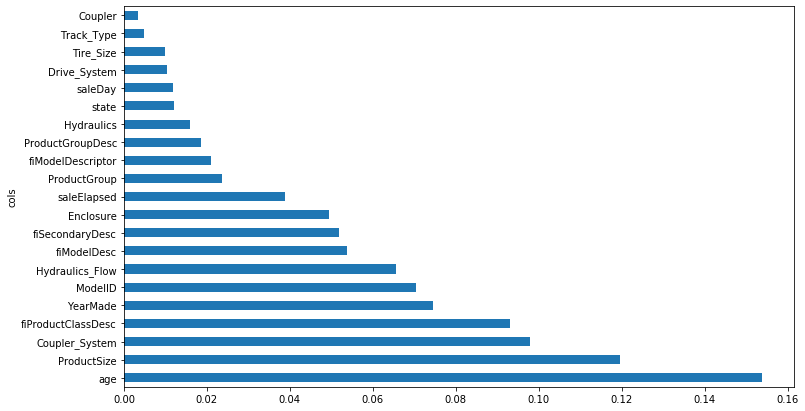

In [0]:
plot_fi(rf_feat_importance(m, X_train));

In [0]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [0]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 7min 27s, sys: 13.5 s, total: 7min 40s
Wall time: 4min 2s
[0.07994382384444895, 0.2117509583310769, 0.9866431311722961, 0.9199246689129179, 0.9145477501602255]


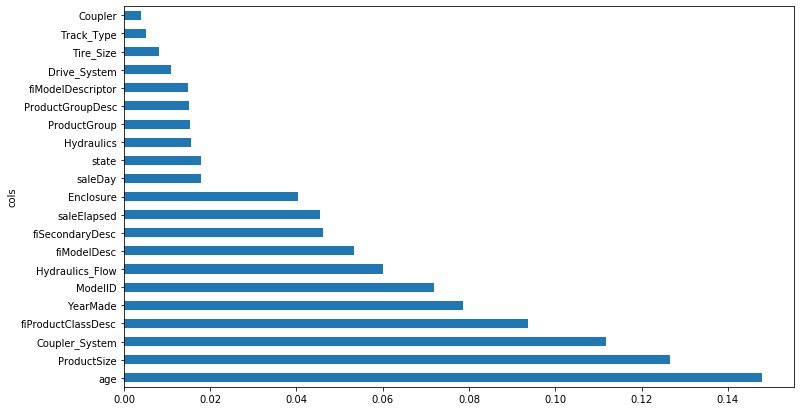

In [0]:
plot_fi(rf_feat_importance(m, X_train));